In [1]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import folium
import numpy as np
from folium.raster_layers import ImageOverlay


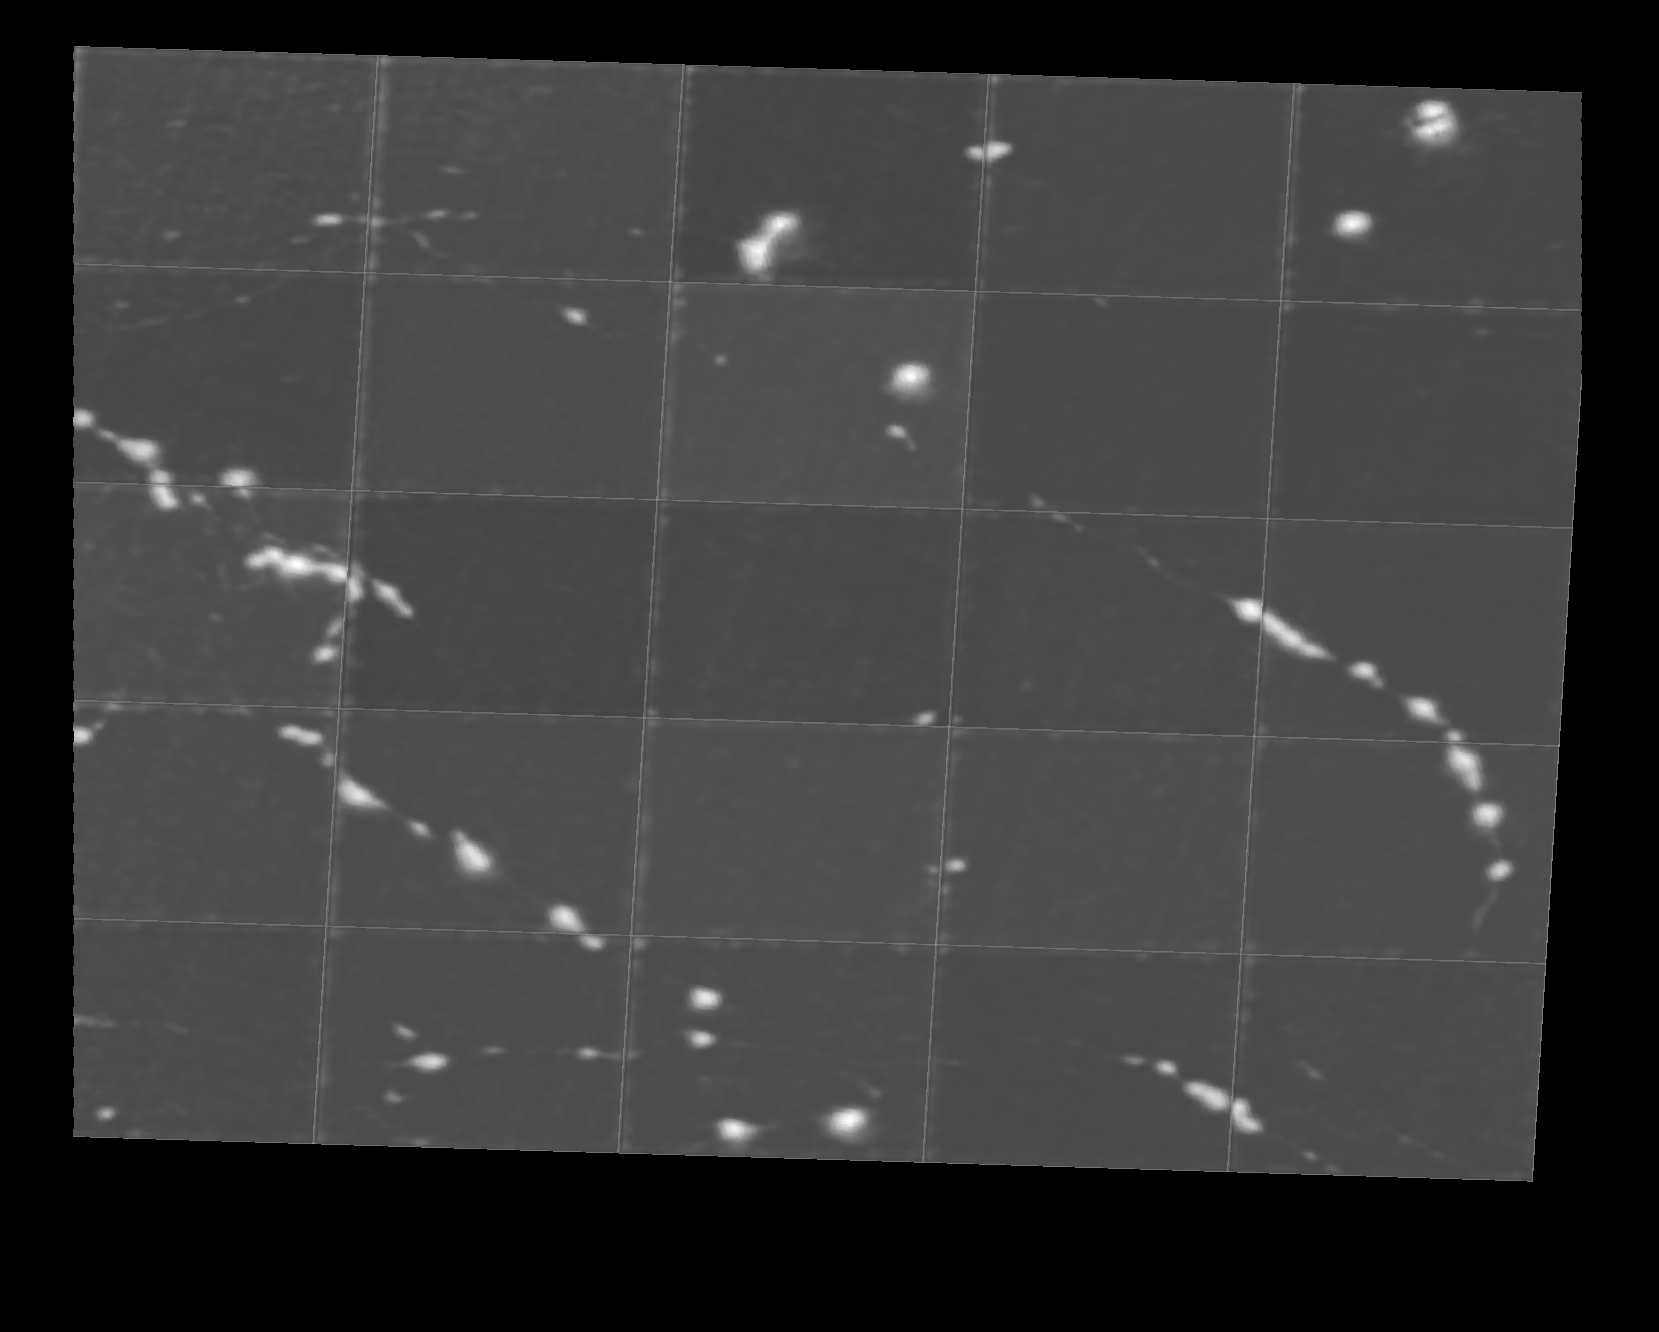

In [3]:
# Path to your .tif file
tif_path = "/home/ubuntu/mucilage_pipeline/DeltaTwin-od-mucilage/models/mucilage_mask_S2B_MSIL2A_20240708T095549_N0510_R122_T32TQQ_20240708T124046.tif"

with rasterio.open(tif_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, 'EPSG:4326', src.width, src.height, *src.bounds)
    
    reprojected = np.zeros((height, width), dtype=src.dtypes[0])
    reproject(
        source=rasterio.band(src, 1),  # first band = prob_map
        destination=reprojected,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=transform,
        dst_crs='EPSG:4326',
        resampling=Resampling.nearest
    )

# Normalize 0-255
norm = ((reprojected - reprojected.min()) / (reprojected.max() - reprojected.min()) * 255).astype(np.uint8)

# Convert to RGB
rgb = np.stack([norm]*3, axis=-1)  # shape: H x W x 3

# Bounding box in lat/lon
bounds = rasterio.transform.array_bounds(height, width, transform)
bbox = [[bounds[1], bounds[0]], [bounds[3], bounds[2]]]  # [[south, west], [north, east]]

# Center map
center = [(bounds[1] + bounds[3])/2, (bounds[0] + bounds[2])/2]

# Create map with a base map
m = folium.Map(location=center, zoom_start=10, tiles="OpenStreetMap")

# Overlay raster
ImageOverlay(image=norm, bounds=bbox, opacity=0.6, interactive=True).add_to(m)

m